# Model Selection

In [5]:
# Importation des différentes librairies utilisées
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import VarianceThreshold, RFECV, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.linear_model import Lasso, LassoCV
from statsmodels.tools import add_constant
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
import statsmodels.api as sm
from statistics import mean

In [6]:
# On définit les datasets et la variable de prédiction
df = pd.read_csv('data_unscaled.csv', index_col=0)
df_scaled = pd.read_csv('data_scaled.csv', index_col=0)
prediction = 'high_blood_pressure'

# On importe la liste des variables binaires
co_binaires_bis = pd.read_csv('co_binaires_bis', index_col=0)
co_binaires_bis = co_binaires_bis.values.tolist()
co_binaires_bis = sum(co_binaires_bis, [])

## Feature Selection

Nous allons mettre en place plusieurs méthodes de sélection des variables afin de les comparer par la suite avec nos différents modèles.

### Méthode Lasso

In [7]:
# Définition du DataSet
X = df_scaled.drop(prediction, axis=1)
y = df_scaled[prediction]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [10]:
# On utilise le lasso pour choisir les features les plus intéressantes
def make_lasso(dataframe, alpha=1):
    df2 = dataframe.select_dtypes(include=np.number)
    yindex = df2.columns.get_loc(prediction)
    lasso1 = Lasso(fit_intercept=False, normalize=False, alpha=alpha)
    lasso1.fit(X, y)
    return lasso1, df2, yindex

my_alphas = np.arange(0.001, 1, 0.001)
lcv = LassoCV(alphas=my_alphas, normalize=False, fit_intercept=False, random_state=0, cv=5).fit(X, y)
lcv.alpha_

0.005

In [11]:
# On crée une liste avec le noms des features les plus intéressantes
lasso3, data, yindex = make_lasso(df_scaled, alpha=lcv.alpha_)
features_select_lasso = list(df_scaled.select_dtypes(include=np.number).drop(prediction, axis=1).columns[np.abs(lasso3.coef_) > 0])

In [12]:
# Définition du nouveau dataset
co_binaires_lasso = []
co_continues_lasso = []
for co in features_select_lasso:
    if co in co_binaires_bis:
        co_binaires_lasso.append(co)
    else :
        co_continues_lasso.append(co)
        
X_lasso = X[features_select_lasso]
X_train_lasso = X_train[features_select_lasso]
X_test_lasso = X_test[features_select_lasso]

In [13]:
len(features_select_lasso)

48

On obtient alors une sélection de 48 variables avec la méthode Lasso.

### Méthode Variance

In [14]:
# Définition du selector avec la méthode de la variance (supprimer toutes les caractéristiques dont la variance n'atteint pas le seuil choisi)
selector = VarianceThreshold(threshold=0.15)

selector.fit_transform(X)
features_select_var = list(np.array(list(X))[selector.get_support()])

X_var = X[features_select_var]
X_train_var = X_train[features_select_var]
X_test_var = X_test[features_select_var]

co_binaires_var = []
co_continues_var = []
for co in features_select_var:
    if co in co_binaires_bis:
        co_binaires_var.append(co)
    else :
        co_continues_var.append(co)

In [15]:
len(features_select_var)

70

Nous obtenons alors une sélection de 70 variables avec la méthode de la variance.

### Méthode RFECV

Optimal number of features : 32


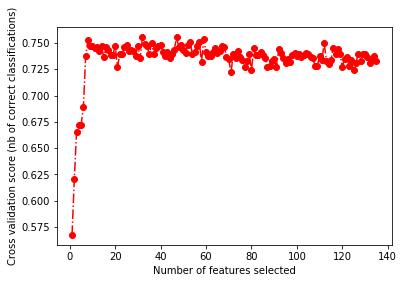

In [16]:
# Définition du selector et graphique donnant le score en fonction du nombre de features 
rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=5,
              scoring='f1_weighted')
rfecv.fit(X, y)
features_select_rfe = list(np.array(list(X))[rfecv.get_support()])
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 'or-.')
plt.show()

In [17]:
# Définiton du nouveau dataset
co_binaires_rfe = []
co_continues_rfe = []
for co in features_select_rfe:
    if co in co_binaires_bis:
        co_binaires_rfe.append(co)
    else :
        co_continues_rfe.append(co)

X_rfe = X[features_select_rfe]

X_train_rfe = X_train[features_select_rfe]
X_test_rfe = X_test[features_select_rfe]

Pour la méthode RFE, qui est une méthode consistant à sélectionner des caractéristiques en considérant de manière récursive, des ensembles de caractéristiques de plus en plus petits, nous obtenons un nombre optimal de features de 32.

## Logistic Regression

On effectue alors une régression logistique en utilisant la sélection de variables obtenue avec la méthode de la variance, pour la prédiction de l'hypertension artérielle (variable 'high_blood_pressure').

In [28]:
# On ajoute une constante aux colonnes pour pouvoir faire la régression avec statsmodels
X_bis = add_constant(X[features_select_var])

In [29]:
logreg = sm.Logit(y, X_bis)
result = logreg.fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.418103
         Iterations 9


In [36]:
print(result.summary())

                            Logit Regression Results                           
Dep. Variable:     high_blood_pressure   No. Observations:                 1291
Model:                           Logit   Df Residuals:                     1220
Method:                            MLE   Df Model:                           70
Date:                 Sun, 13 Dec 2020   Pseudo R-squ.:                  0.3245
Time:                         16:14:24   Log-Likelihood:                -539.77
converged:                        True   LL-Null:                       -799.09
Covariance Type:             nonrobust   LLR p-value:                 1.096e-69
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -4.7986      0.698     -6.874      0.000      -6.167      -3.430
overweight                        0.4666      0.188      2.488    

Grâce à cette régression, nous remarquons certaines relations entre les variables que nous avions pu supposer dans la partie de statistiques précédente. En effet, par exemple, nous remarquons que le fait que le médecin donne l'ordre au patient de réduire sa consommation de sel (*order_to_reduce_salt*) est corrélé au fait qu'il puisse avoir de l'hypertension, de même que l'âge. On obtient un $R^2$ d'environ 0.32, ce qui présage que nous allons obtenir sûrement de bons résultats par la suite.

## Model Selection

In [37]:
# Définiton des dictionnaires des hyperparamètres
dico_param_tree = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
         'decisiontreeclassifier__splitter': ['best', 'random']}
dico_param_rf = {"randomforestclassifier__n_estimators": np.arange(10, 100, 20),
              "randomforestclassifier__criterion": ['gini', 'entropy'],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2'],
              "randomforestclassifier__random_state": [None, 0, 42],
              "randomforestclassifier__class_weight": [None, 'balanced']}
dico_param_log = {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

model_rf = make_pipeline(RandomForestClassifier())
model_tree = make_pipeline(DecisionTreeClassifier())
model_log = make_pipeline(LogisticRegression(max_iter=10000))

In [42]:
# On recherche les meilleurs hyperparamètres pour chaque modèle
SCORING = 'f1_weighted' # on veut que 'recall' et 'precision' importent

# Définition d'une fonction donnant les meilleurs paramètres
def best_param(X, y, pipeline, dico_param, co_continues):
    grid = GridSearchCV(
        pipeline, 
        param_grid=dico_param,  
        cv=5, 
        refit=True, # à la fin, il sélectionne le meilleur jeu d'hyperparamètres et réentraîne le modèle sur toutes les données
        scoring=SCORING)
    grid.fit(X, y)
    print(f"Best estimator has {SCORING}={round(grid.best_score_, 2)}")
    best_model = grid.best_estimator_
    print("Le meilleur modèle est :", best_model)
    return best_model

### Sélection des hyperparamètres pour RandomForest

In [43]:
# Recherche des meilleurs paramètres pour RandomForest pour lasso
best_model_rf_lasso = best_param(X_lasso, y, model_rf, dico_param_rf, co_continues_lasso)

Best estimator has f1_weighted=0.76
Le meilleur modèle est : Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=90))])


In [44]:
# Recherche des meilleurs paramètres pour RandomForest pour Var
best_model_rf_var = best_param(X_var, y, model_rf, dico_param_rf, co_continues_var)

Best estimator has f1_weighted=0.75
Le meilleur modèle est : Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=50,
                                        random_state=0))])


In [45]:
# Recherche des meilleurs paramètres pour RandomForest pour RFECV
best_model_rf_rfe = best_param(X_rfe, y, model_rf, dico_param_rf, co_continues_rfe)

Best estimator has f1_weighted=0.76
Le meilleur modèle est : Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_estimators=90, random_state=0))])


In [58]:
# On garde que le modèle et non la pipeline
best_model_rf_lasso = best_model_rf_lasso[0]
best_model_rf_var = best_model_rf_var[0]
best_model_rf_rfe = best_model_rf_rfe[0]

Pour le modèle RandomForest, on remarque que le meilleur estimateur est celui avec la sélection de variables de Lasso, ainsi qu'avec celui du RFE, qui donnent tous les deux un score f1 de 0.76.

### Sélection des hyperparamètres pour Decision Tree

In [46]:
# Recherche des meilleurs paramètres pour DecisionTree pour lasso
best_model_tree_lasso = best_param(X_lasso, y, model_tree, dico_param_tree, co_continues_lasso)

Best estimator has f1_weighted=0.69
Le meilleur modèle est : Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(splitter='random'))])


In [47]:
# Recherche des meilleurs paramètres pour DecisionTree pour Var
best_model_tree_var = best_param(X_var, y, model_tree, dico_param_tree, co_continues_var)

Best estimator has f1_weighted=0.71
Le meilleur modèle est : Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy'))])


In [48]:
# Recherche des meilleurs paramètres pour DecisionTree pour RFECV
best_model_tree_rfe = best_param(X_rfe, y, model_tree, dico_param_tree, co_continues_rfe)

Best estimator has f1_weighted=0.7
Le meilleur modèle est : Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(splitter='random'))])


In [49]:
best_model_tree_lasso = best_model_tree_lasso[0]
best_model_tree_var = best_model_tree_var[0]
best_model_tree_rfe = best_model_tree_rfe[0]

Pour le modèle DecisionTree, on remarque que le meilleur estimateur est celui avec la sélection de variables de la variance qui donne un score f1 de 0.71.

### Sélection des hyperparamètres pour Logistic Regression

In [51]:
# Recherche des meilleurs paramètres pour LogisticRegression pour lasso
best_model_log_lasso = best_param(X_lasso, y, model_log, dico_param_log, co_continues_lasso)

Best estimator has f1_weighted=0.77
Le meilleur modèle est : Pipeline(steps=[('logisticregression',
                 LogisticRegression(max_iter=10000, solver='newton-cg'))])


In [52]:
# Recherche des meilleurs paramètres pour LogisticRegression pour Var
best_model_log_var = best_param(X_var, y, model_log, dico_param_log, co_continues_var)

Best estimator has f1_weighted=0.77
Le meilleur modèle est : Pipeline(steps=[('logisticregression',
                 LogisticRegression(max_iter=10000, solver='sag'))])


In [53]:
# Recherche des meilleurs paramètres pour LogisticRegression pour RFECV
best_model_log_rfe = best_param(X_rfe, y, model_log, dico_param_log, co_continues_rfe)

Best estimator has f1_weighted=0.77
Le meilleur modèle est : Pipeline(steps=[('logisticregression',
                 LogisticRegression(max_iter=10000, solver='sag'))])


In [54]:
best_model_log_lasso = best_model_log_lasso[0]
best_model_log_var = best_model_log_var[0]
best_model_log_rfe = best_model_log_rfe[0]

Pour le modèle LogisticRegression, les modèles ont tous le même score suivant les trois sélections de variables, mais avec des hyperparamètres différents.

### Résultats selon la sélection de variables par modèle

Nous cherchons maintenant, à partir des meilleurs modèles trouvés précédemment, à avoir plus de données sur des scores différents, mais aussi, à obtenir les caractéristiques qui semblent les plus importantes pour prédire l'hypertension artérielle.

In [55]:
# Définition d'une fonction pour entraîner un modèle
def fit(X, X_test, y, co_continues, model):
    
    accuracy = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='accuracy'))
    auc = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='roc_auc'))
    precision = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='precision'))
    f1_weighted = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='f1_weighted'))
    proba = model.predict_proba(X_test)[:,1]
    
    print('The f1_weighted score pour le modèle : {:.3g}'.format(f1_weighted))
    print('Pourcentage de bien classés pour le modèle : {:.3g}'.format(accuracy))
    print('Aire sous la courbe ROC pour le modèle : {:.3g}'.format(auc))
    print('La précision pour le modèle : {:.3g}'.format(precision))
    
    return accuracy, auc, precision, f1_weighted, proba

In [56]:
# Définition d'une fonction qui renvoie les meilleures features par rapport à la variance
def best_features(model, X_train, threshold) :     
    features_importances = []
    index_best_features = []
    list_results = model.feature_importances_.tolist()
    best_features = []
    for i in range(len(list_results)):
        if list_results[i] > threshold :
            index_best_features.append(i)
            features_importances.append(list_results[i])
            best_features.append(X_train.columns[i])
    return best_features, features_importances

The f1_weighted score pour le modèle : 0.743
Pourcentage de bien classés pour le modèle : 0.76
Aire sous la courbe ROC pour le modèle : 0.825
La précision pour le modèle : 0.699


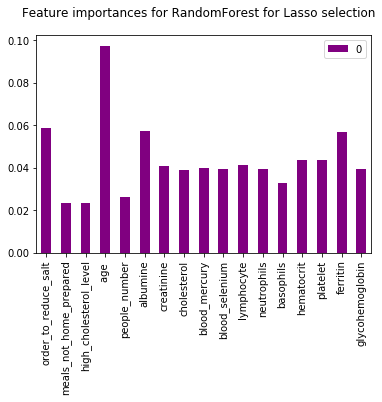

In [59]:
# Modèle RandomForest avec la sélection lasso
accuracy_rf_lasso, auc_rf_lasso, precision_rf_lasso, f1_weighted_rf_lasso, proba_rf_lasso = fit(X_lasso, X_test_lasso, y, co_continues_lasso, best_model_rf_lasso)

best_features_rf_lasso, features_importance_rf_lasso = best_features(best_model_rf_lasso, X_train_lasso, 0.02)

pd.DataFrame(features_importance_rf_lasso, index = best_features_rf_lasso).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest for Lasso selection')
plt.legend()

Nous remarquons que pour le modèle RandomForest avec la sélection Lasso, la caractéristique qui semble la plus importante est l'âge, mais nous avons aussi plusieurs caractéristiques sanguines comme le taux d'albumine, de créatinine ou encore de ferritine. On retrouve également comme variables la recommandation de réduire sa consommation de sel, ou le fait de manger des plats tout préparés.

The f1_weighted score pour le modèle : 0.754
Pourcentage de bien classés pour le modèle : 0.773
Aire sous la courbe ROC pour le modèle : 0.818
La précision pour le modèle : 0.727


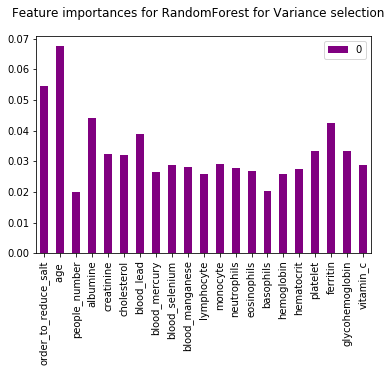

In [69]:
# Modèle RandomForest avec la sélection Var
accuracy_rf_var, auc_rf_var, precision_rf_var, f1_weighted_rf_var, proba_rf_var = fit(X_var, X_test_var, y, co_continues_var, best_model_rf_var)

best_features_rf_var, features_importance_rf_var = best_features(best_model_rf_var, X_train_var, 0.02)

pd.DataFrame(features_importance_rf_var, index = best_features_rf_var).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest for Variance selection')
plt.legend()

Nous retrouvons ici un score f1 qui est supérieur au précédent avec la sélection de variables de la variance. Nous remarquons que plusieurs variables en plus apparaissent comme le taux de vitamine C ou encore celui de l'hémoglobine.

The f1_weighted score pour le modèle : 0.759
Pourcentage de bien classés pour le modèle : 0.773
Aire sous la courbe ROC pour le modèle : 0.816
La précision pour le modèle : 0.696


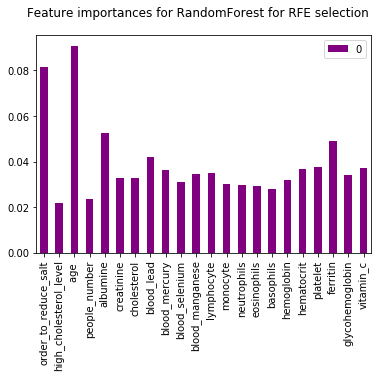

In [60]:
# Modèle RandomForest avec la sélection RFE
accuracy_rf_rfe, auc_rf_rfe, precision_rf_rfe, f1_weighted_rf_rfe, proba_rf_rfe = fit(X_rfe, X_test_rfe, y, co_continues_rfe, best_model_rf_rfe)

best_features_rf_rfe, features_importance_rf_rfe = best_features(best_model_rf_rfe, X_train_rfe, 0.02)

pd.DataFrame(features_importance_rf_rfe, index = best_features_rf_rfe).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest for RFE selection')
plt.legend()

The f1_weighted score pour le modèle : 0.683
Pourcentage de bien classés pour le modèle : 0.695
Aire sous la courbe ROC pour le modèle : 0.635
La précision pour le modèle : 0.516


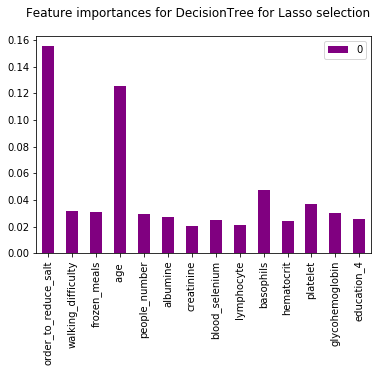

In [61]:
# Modèle DecisionTree avec la sélection lasso
accuracy_tree_lasso, auc_tree_lasso, precision_tree_lasso, f1_weighted_tree_lasso, proba_tree_lasso = fit(X_lasso, X_test_lasso, y, co_continues_lasso, best_model_tree_lasso)

best_features_tree_lasso, features_importance_tree_lasso = best_features(best_model_tree_lasso, X_train_lasso, 0.02)

pd.DataFrame(features_importance_tree_lasso, index = best_features_tree_lasso).plot.bar(color='purple')
plt.suptitle('Feature importances for DecisionTree for Lasso selection')
plt.legend()

Pour le modèle DecisionTree, nous pouvons voir que les résultats sont en moyenne beaucoup moins bons que pour le modèle RandomForest. Cependant, les caractéristiques choisies sont presque les mêmes.

The f1_weighted score pour le modèle : 0.69
Pourcentage de bien classés pour le modèle : 0.696
Aire sous la courbe ROC pour le modèle : 0.649
La précision pour le modèle : 0.511


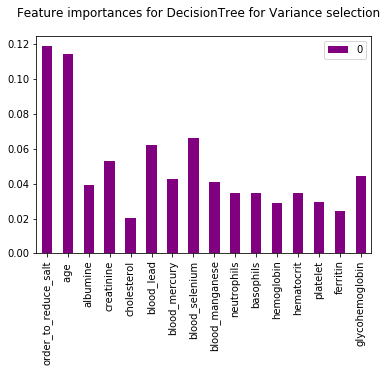

In [62]:
# Modèle DecisionTree avec la sélection Var
accuracy_tree_var, auc_tree_var, precision_tree_var, f1_weighted_tree_var, proba_tree_var = fit(X_var, X_test_var, y, co_continues_var, best_model_tree_var)

best_features_tree_var, features_importance_tree_var = best_features(best_model_tree_var, X_train_var, 0.02)

pd.DataFrame(features_importance_tree_var, index = best_features_tree_var).plot.bar(color='purple')
plt.suptitle('Feature importances for DecisionTree for Variance selection')
plt.legend()

The f1_weighted score pour le modèle : 0.686
Pourcentage de bien classés pour le modèle : 0.665
Aire sous la courbe ROC pour le modèle : 0.633
La précision pour le modèle : 0.485


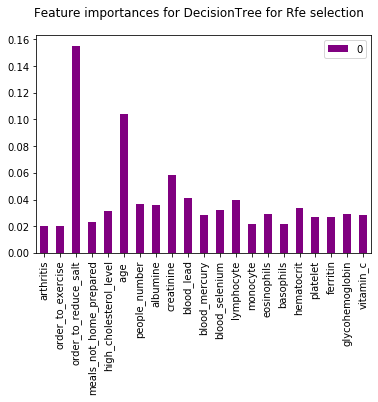

In [63]:
# Modèle DecisionTree avec la sélection Rfe
accuracy_tree_rfe, auc_tree_rfe, precision_tree_rfe, f1_weighted_tree_rfe, proba_tree_rfe = fit(X_rfe, X_test_rfe, y, co_continues_rfe, best_model_tree_rfe)

best_features_tree_rfe, features_importance_tree_rfe = best_features(best_model_tree_rfe, X_train_rfe, 0.02)

pd.DataFrame(features_importance_tree_rfe, index = best_features_tree_rfe).plot.bar(color='purple')
plt.suptitle('Feature importances for DecisionTree for Rfe selection')
plt.legend()

In [64]:
# Modèle LogisticRegression avec la sélection lasso
accuracy_log_lasso, auc_log_lasso, precision_log_lasso, f1_weighted_log_lasso, proba_log_lasso = fit(X_lasso, X_test_lasso, y, co_continues_lasso, best_model_log_lasso)

The f1_weighted score pour le modèle : 0.775
Pourcentage de bien classés pour le modèle : 0.783
Aire sous la courbe ROC pour le modèle : 0.835
La précision pour le modèle : 0.691


Nous remarquons que le modèle LogisticRegression donne de meilleurs résultats que les deux modèles précédents, puisque son score f1 donne de meilleurs résultats.

In [66]:
# Modèle LogisticRegression avec la sélection Var
accuracy_log_var, auc_log_var, precision_log_var, f1_weighted_log_var, proba_log_var = fit(X_var, X_test_var, y, co_continues_var, best_model_log_var)

The f1_weighted score pour le modèle : 0.769
Pourcentage de bien classés pour le modèle : 0.778
Aire sous la courbe ROC pour le modèle : 0.821
La précision pour le modèle : 0.676


In [67]:
# Modèle LogisticRegression avec la sélection rfe
accuracy_log_rfe, auc_log_rfe, precision_log_rfe, f1_weighted_log_rfe, proba_log_rfe =fit(X_rfe, X_test_rfe, y, co_continues_rfe, best_model_log_rfe)

The f1_weighted score pour le modèle : 0.772
Pourcentage de bien classés pour le modèle : 0.782
Aire sous la courbe ROC pour le modèle : 0.828
La précision pour le modèle : 0.697


La meilleure sélection de variables pour le modèle LogisticRegression est la sélection avec le Lasso.

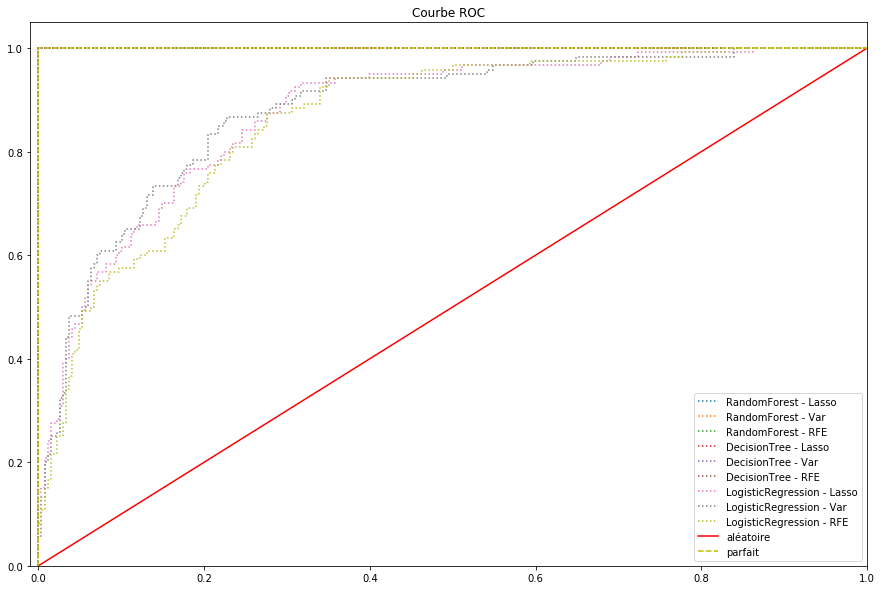

In [72]:
# On effectue une Courbe ROC
plt.figure(1, figsize=(15, 10))
# cas du modèle RandomForest
fpr, tpr, _ = roc_curve(y_test, proba_rf_lasso)
plt.plot(fpr,tpr,":", label="RandomForest - Lasso")

fpr, tpr, _ = roc_curve(y_test, proba_rf_var)
plt.plot(fpr,tpr,":", label="RandomForest - Var")

fpr, tpr, _ = roc_curve(y_test, proba_rf_rfe)
plt.plot(fpr,tpr,":", label="RandomForest - RFE")

# cas du modèle DecisionTree
fpr, tpr, _ = roc_curve(y_test, proba_tree_lasso)
plt.plot(fpr,tpr,":", label="DecisionTree - Lasso")

fpr, tpr, _ = roc_curve(y_test, proba_tree_var)
plt.plot(fpr,tpr,":", label="DecisionTree - Var")

fpr, tpr, _ = roc_curve(y_test, proba_tree_rfe)
plt.plot(fpr,tpr,":", label="DecisionTree - RFE")

# cas du modèle LogisticRegression
fpr, tpr, _ = roc_curve(y_test, proba_log_lasso)
plt.plot(fpr,tpr,":", label="LogisticRegression - Lasso")

fpr, tpr, _ = roc_curve(y_test, proba_log_var)
plt.plot(fpr,tpr,":", label="LogisticRegression - Var")

fpr, tpr, _ = roc_curve(y_test, proba_log_rfe)
plt.plot(fpr,tpr,":", label="LogisticRegression - RFE")

# modèle aléatoire
plt.plot([0, 1], [0, 1], "r-", label="aléatoire")

# modèle parfait
plt.plot([0,0, 1], [0,1, 1], 'y--', label="parfait")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Courbe ROC')
plt.legend()

Ce graphique résume toutes les observations que nous avons pu faire jusqu'à présent.

### Graphique montrant les différentes sélections pour chaque modèle


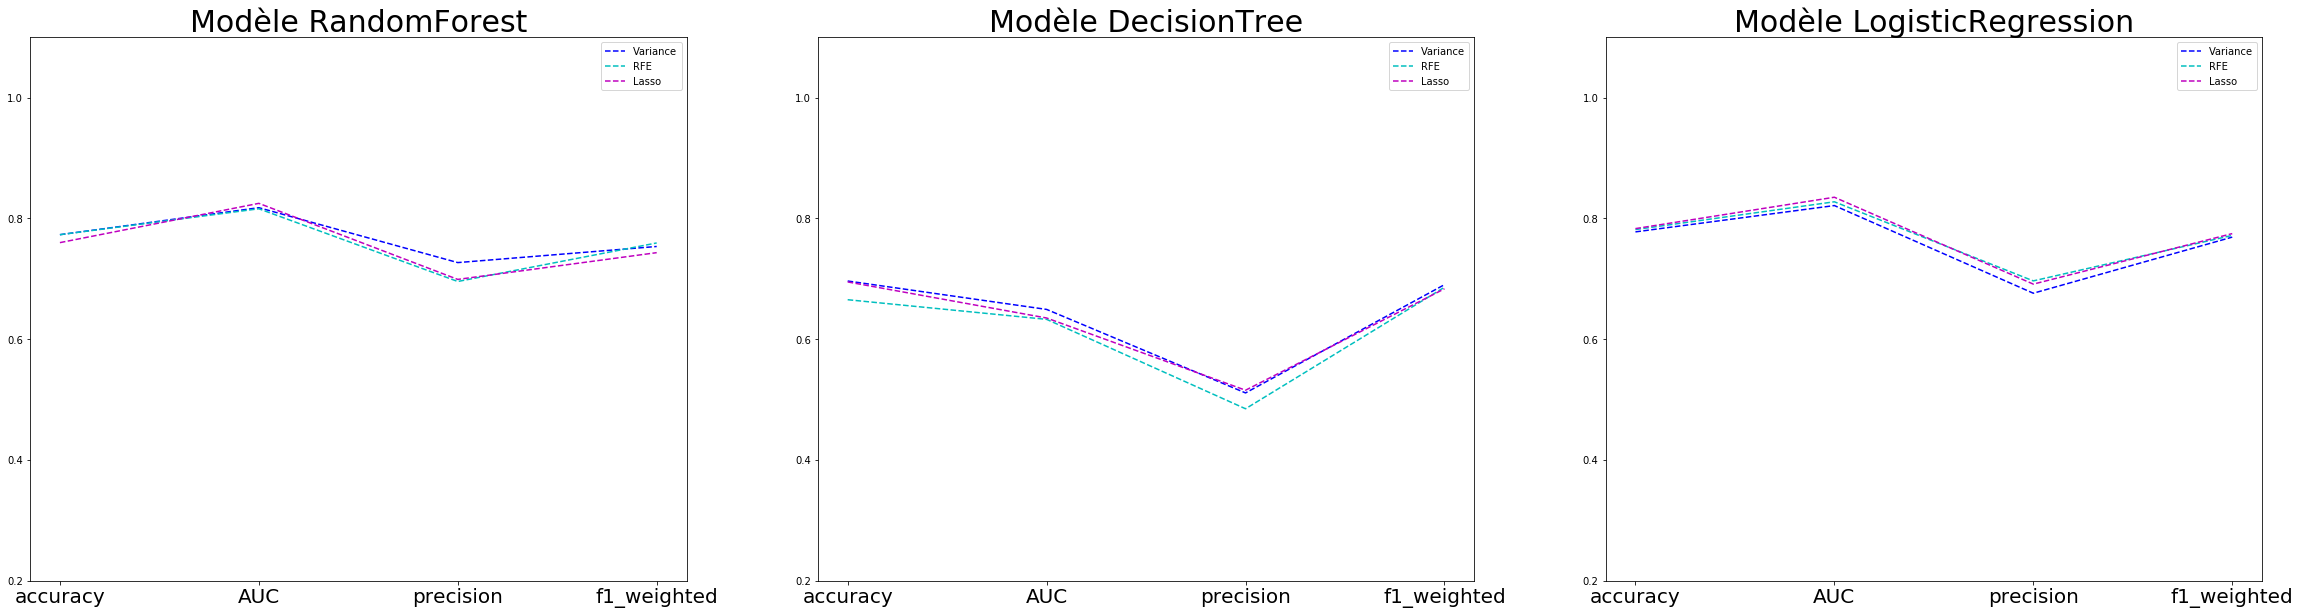

In [80]:
# Graphiques de résumé
X = ['accuracy', 'AUC', 'precision', 'f1_weighted']

Y_rf_lasso = [accuracy_rf_lasso, auc_rf_lasso, precision_rf_lasso, f1_weighted_rf_lasso]
Y_rf_var = [accuracy_rf_var, auc_rf_var, precision_rf_var, f1_weighted_rf_var]
Y_rf_rfe = [accuracy_rf_rfe, auc_rf_rfe, precision_rf_rfe, f1_weighted_rf_rfe]

Y_tree_lasso = [accuracy_tree_lasso, auc_tree_lasso, precision_tree_lasso, f1_weighted_tree_lasso]
Y_tree_var = [accuracy_tree_var, auc_tree_var, precision_tree_var, f1_weighted_tree_var]
Y_tree_rfe = [accuracy_tree_rfe, auc_tree_rfe, precision_tree_rfe, f1_weighted_tree_rfe]

Y_log_lasso = [accuracy_log_lasso, auc_log_lasso, precision_log_lasso, f1_weighted_log_lasso]
Y_log_var = [accuracy_log_var, auc_log_var, precision_log_var, f1_weighted_log_var]
Y_log_rfe = [accuracy_log_rfe, auc_log_rfe, precision_log_rfe, f1_weighted_log_rfe]

plt.figure(1, figsize=(40, 10))
plt.subplot(1, 3, 1)
plt.plot(X, Y_rf_var, 'b--', label='Variance')
plt.plot(X, Y_rf_rfe, 'c--', label='RFE')
plt.plot(X, Y_rf_lasso, 'm--', label='Lasso')
plt.gca().get_xaxis().set_ticklabels(X, fontsize=20)
plt.ylim(0.2, 1.1)
plt.title('Modèle RandomForest', fontsize=30)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(X, Y_tree_var, 'b--', label='Variance')
plt.plot(X, Y_tree_rfe, 'c--', label='RFE')
plt.plot(X, Y_tree_lasso, 'm--', label='Lasso')
plt.gca().get_xaxis().set_ticklabels(X, fontsize=20)
plt.ylim(0.2,1.1)
plt.title('Modèle DecisionTree', fontsize=30)
plt.legend()

plt.subplot(1,3,3)
plt.plot(X, Y_log_var, 'b--', label='Variance')
plt.plot(X, Y_log_rfe, 'c--', label='RFE')
plt.plot(X, Y_log_lasso, 'm--', label='Lasso')
plt.gca().get_xaxis().set_ticklabels(X, fontsize=20)
plt.ylim(0.2, 1.1)
plt.title('Modèle LogisticRegression', fontsize=30)
plt.legend()

Nous remarquons bien que le modèle DecisionTree est bien en dessous des deux autres modèles. 
- Pour le RandomForest, la meilleure sélection de variables semble être celle de la variance.
- Pour le DecisionTree, la meilleure sélection de variables semble être aussi celle de la variance.
- Pour la LogisticRegression, la meilleure sélection de variables semble être celle du Lasso.

## Conclusion de la modélisation

In [81]:
# Définition d'une fonction pour changer les listes des meilleures charactéristiques en dictionnaire
def change_in_dict(best_features, features_importance):
    dict_best_features = dict()
    for i in range(len(best_features)):
        dict_best_features[best_features[i]] = int(features_importance[i] * 100) / 100
    return dict_best_features

In [82]:
# Définition des dictionnaires des meilleures variables
dict_best_features_rf_var = change_in_dict(best_features_rf_var, features_importance_rf_var)
dict_best_features_rf_rfe = change_in_dict(best_features_rf_rfe, features_importance_rf_rfe)
dict_best_features_rf_lasso = change_in_dict(best_features_rf_lasso, features_importance_rf_lasso)

dict_best_features_tree_var = change_in_dict(best_features_tree_var, features_importance_tree_var)
dict_best_features_tree_rfe = change_in_dict(best_features_tree_rfe, features_importance_tree_rfe)
dict_best_features_tree_lasso = change_in_dict(best_features_tree_lasso, features_importance_tree_lasso)

In [83]:
# Définition du dictionnaire commun donnant les meilleures features
dict_best_features = dict()
dict_best = [dict_best_features_rf_var, dict_best_features_rf_rfe, dict_best_features_rf_lasso, dict_best_features_tree_var, dict_best_features_tree_rfe, dict_best_features_tree_lasso]
for dictio in dict_best : 
    for nom, valeur in dictio.items():
        if nom not in dict_best_features:
            dict_best_features[nom] = [valeur]
        else:
            dict_best_features[nom].append(valeur)

In [84]:
# On calcule la moyenne de l'importance de chaque feature
for nom, valeur in dict_best_features.items():
    dict_best_features[nom] = int(sum(valeur) / len(valeur) * 100) / 100

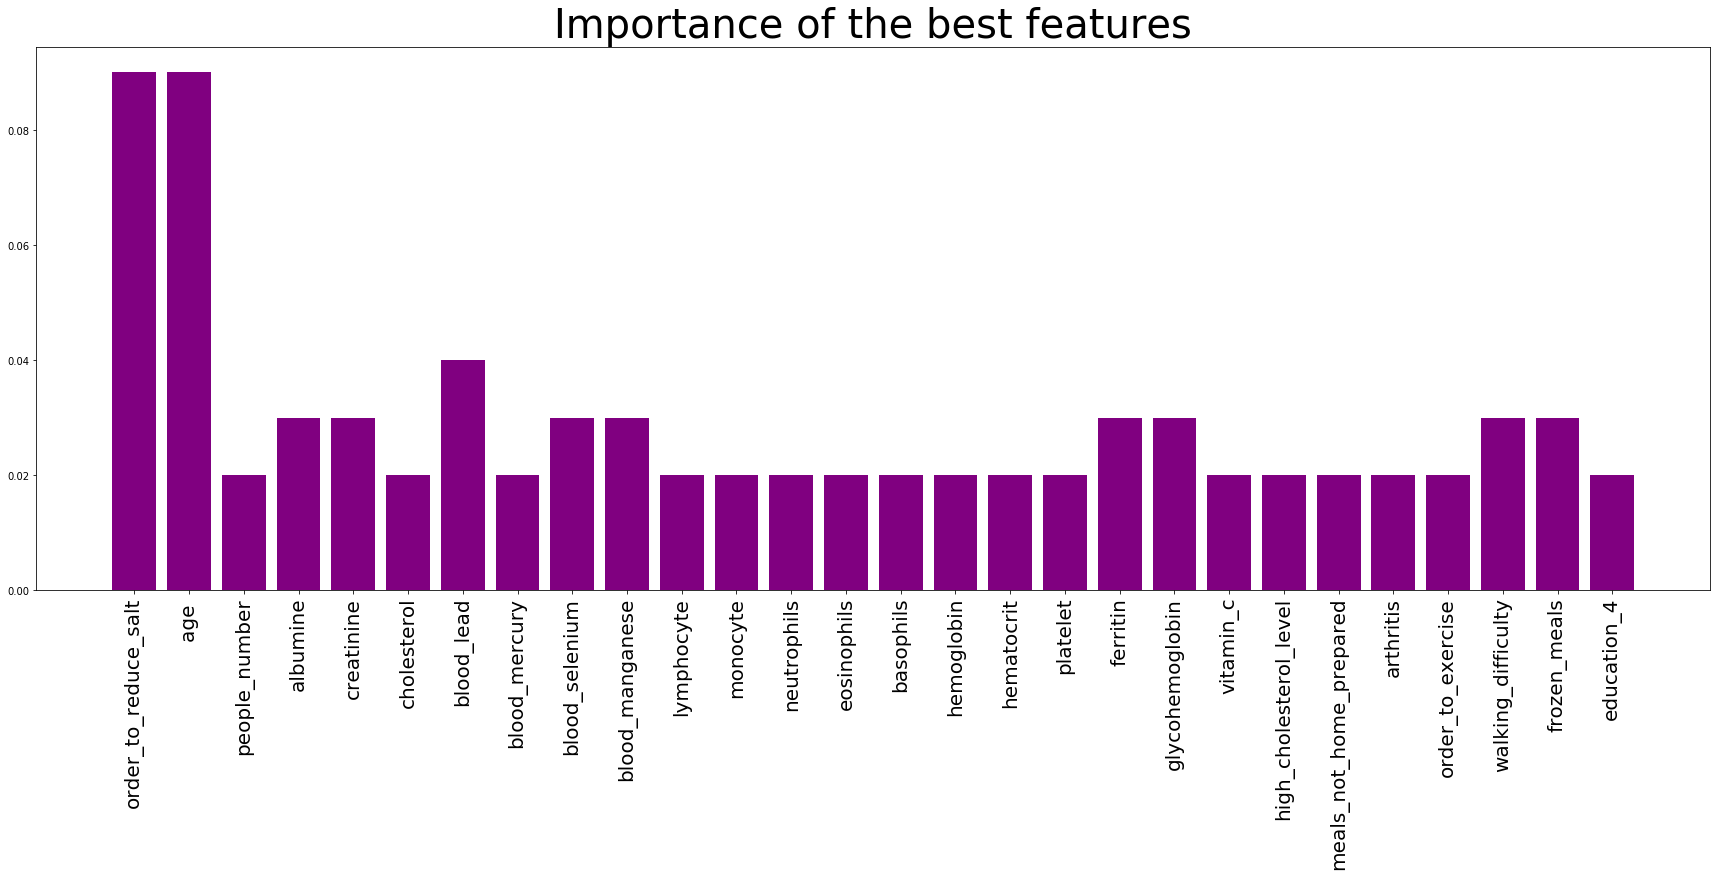

In [87]:
# Graphique montrant l'importance des meilleures features
plt.figure(1, figsize=(30, 10))
plt.bar(dict_best_features.keys(), dict_best_features.values(), color='purple')
plt.gca().get_xaxis().set_ticklabels(dict_best_features.keys(), fontsize=20, rotation=90)
plt.title('Importance of the best features', fontsize=40)
plt.show()

En regardant l'importance des meilleures caractéristiques, on remarque que nous avons comme précédemment, pour les plus importantes, l'ordre de réduire le sel, mais aussi l'âge. En suite, nous avons beaucoup de caractéristiques sanguines (taux de plomb dans le sang, taux d'albumine, taux de créatinine...). Ces caractéristiques semblent bien être logiques pour prédire le risque d'hypertension.

RandomForest - F1_weighted: 0.75 (+/- 0.04)
DecisionTree - F1_weighted: 0.69 (+/- 0.02)
LogisticRegression - F1_weighted: 0.77 (+/- 0.05)


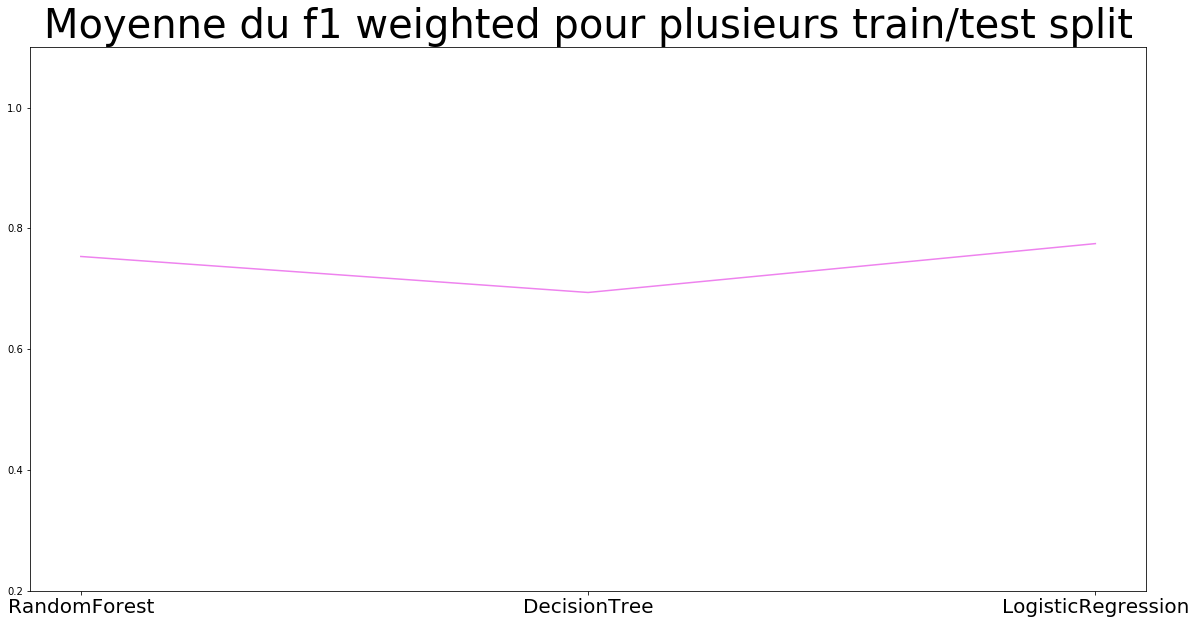

In [89]:
# Moyenne du f1_score pour plusieurs train/test split 
score_rf = cross_val_score(best_model_rf_var, X_var, y, cv=StratifiedKFold(), scoring='f1_weighted')
score_tree = cross_val_score(best_model_tree_var, X_var, y, cv=StratifiedKFold(), scoring='f1_weighted')
score_log = cross_val_score(best_model_log_lasso, X_lasso, y, cv=StratifiedKFold(), scoring='f1_weighted')

print("RandomForest - F1_weighted: %0.2f (+/- %0.2f)" % (score_rf.mean(), score_rf.std() * 2))
print("DecisionTree - F1_weighted: %0.2f (+/- %0.2f)" % (score_tree.mean(), score_tree.std() * 2))
print("LogisticRegression - F1_weighted: %0.2f (+/- %0.2f)" % (score_log.mean(), score_log.std() * 2))


X = ['RandomForest', 'DecisionTree', 'LogisticRegression']
Y = [score_rf.mean(), score_tree.mean(), score_log.mean()]
plt.figure(1, figsize=(20, 10))
plt.plot(X, Y, color='violet')
plt.gca().get_xaxis().set_ticklabels(X, fontsize=20)
plt.ylim(0.2, 1.1)
plt.title('Moyenne du f1 weighted pour plusieurs train/test split', fontsize=40)
plt.show()

Pour conclure, nous obtenons comme résultat que la LogisticRegression est le meilleur modèle de prédiction pour notre objectif, à savoir la prédiction de l'hypertension artérielle. Nous obtenons un score d'environ 0.77. Nous obtiendrons peut-être de meilleurs résultats en ayant plus de données sur les patients. De plus, ces modèles permettent de montrer les caractéristiques qui sont les plus importantes pour prédire l'hypertension artérielle, et notamment de retrouver les corrélations que nous avions pu remarquer durant l'étude des statistiques descriptives de la partie précédente.